In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import gradio as gr


In [2]:
dataset_dir = "archive/TrashType_Image_Dataset"
image_size = (224, 224)  #  CHANGED from (124,124)
batch_size = 32
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))
class_names = train_ds.class_names

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


In [3]:
val_batches = tf.data.experimental.cardinality(val_ds)

# Split validation into test and actual validation
test_ds = val_ds.take(val_batches // 2)
val_dat= val_ds.skip(val_batches // 2)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  


In [4]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
AUTOTUNE = tf.data.AUTOTUNE
preprocess_layer = tf.keras.layers.Lambda(lambda x: preprocess_input(x))

train_ds = train_ds.map(lambda x, y: (preprocess_layer(x), y)).cache().prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_layer(x), y)).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (preprocess_layer(x), y)).cache().prefetch(AUTOTUNE)


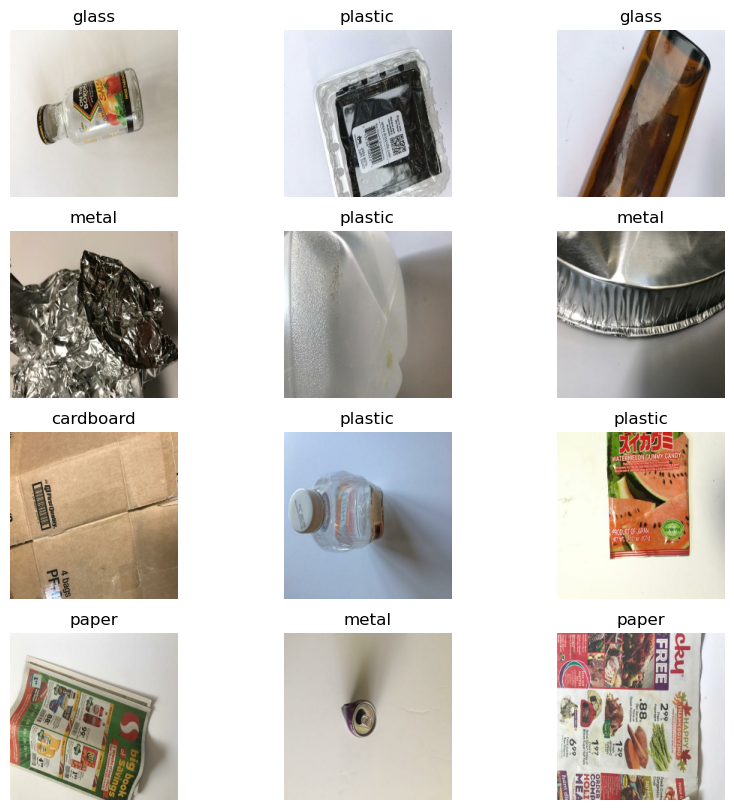

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [7]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [8]:


# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


In [9]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}


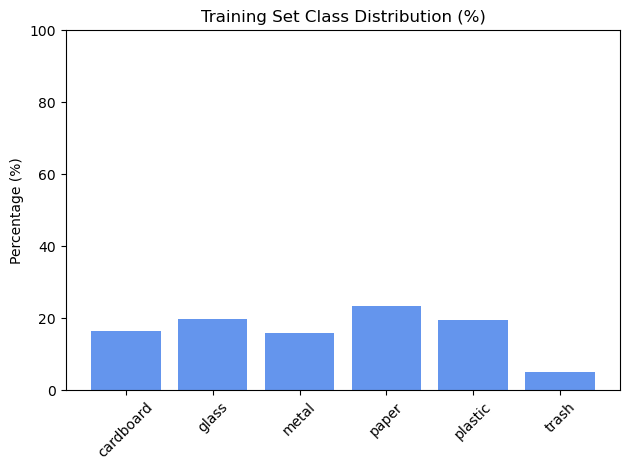

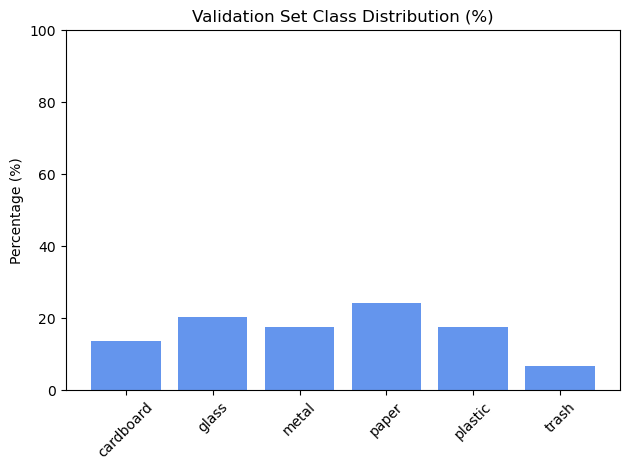

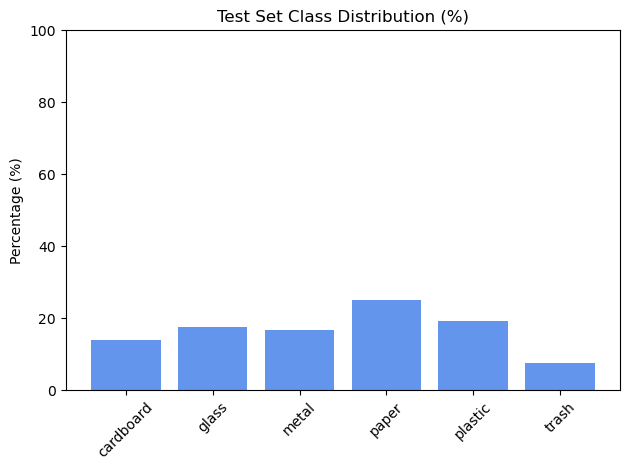

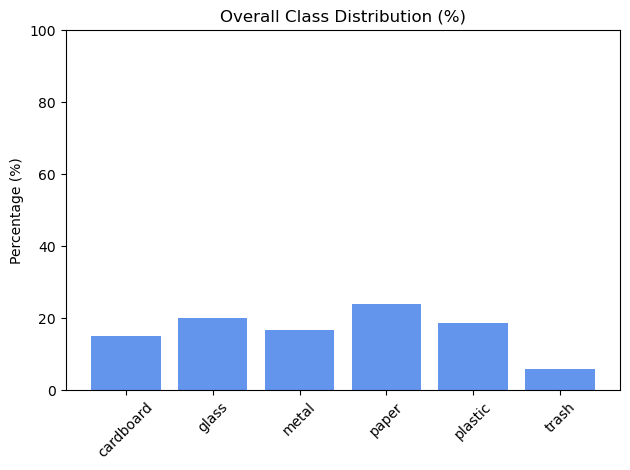

In [10]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [11]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [50]:
#  Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [13]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


In [52]:
base_model = EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

base_model.trainable = True
for layer in base_model.layers[:150]:  #  Previously 100
    layer.trainable = False

model = Sequential([
    Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

In [15]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1
)


In [17]:
epochs = 20  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early_stop]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 555s 5s/step - accuracy: 0.3965 - loss: 1.5839 - val_accuracy: 0.7406 - val_loss: 0.9539
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.7847 - loss: 0.8164 - val_accuracy: 0.8475 - val_loss: 0.5336
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.8574 - loss: 0.5063 - val_accuracy: 0.9010 - val_loss: 0.3839
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 289s 5s/step - accuracy: 0.9202 - loss: 0.3212 - val_accuracy: 0.9089 - val_loss: 0.3121
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 326s 5s/step - accuracy: 0.9377 - loss: 0.2188 - val_accuracy: 0.9089 - val_loss: 0.2957
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.9522 - loss: 0.1704 - val_accuracy: 0.9188 - val_loss: 0.2608
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9810 - loss: 0.0965 - val_accuracy: 0.9188 - val_loss: 0.2645
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.9835 - loss: 0.0840 - val_accuracy: 0.9228 - v

In [18]:
import numpy as np

# Save training history
np.save('updated_model_history.npy', history.history)

# Save test accuracy
_, test_acc_new = model.evaluate(test_ds_eval)
np.save('updated_model_test_acc.npy', test_acc_new)


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9162 - loss: 0.2478


In [19]:
# Summary (optional but useful)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 7, 7, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,328,650 (88.99 MB)

 Trainable params: 7,275,410 (27.75 MB)

 Non-trainable params: 1,502,418 (5.73 MB)

 Optimizer params: 14,550,822 (55.51 MB)

In [20]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 112, 112, 16)      │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 112, 112, 16)      │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 112, 112, 16)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 112, 112, 16)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 112, 112, 16)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 56, 56, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,266,956 (27.72 MB)

 Non-trainable params: 1,502,418 (5.73 MB)

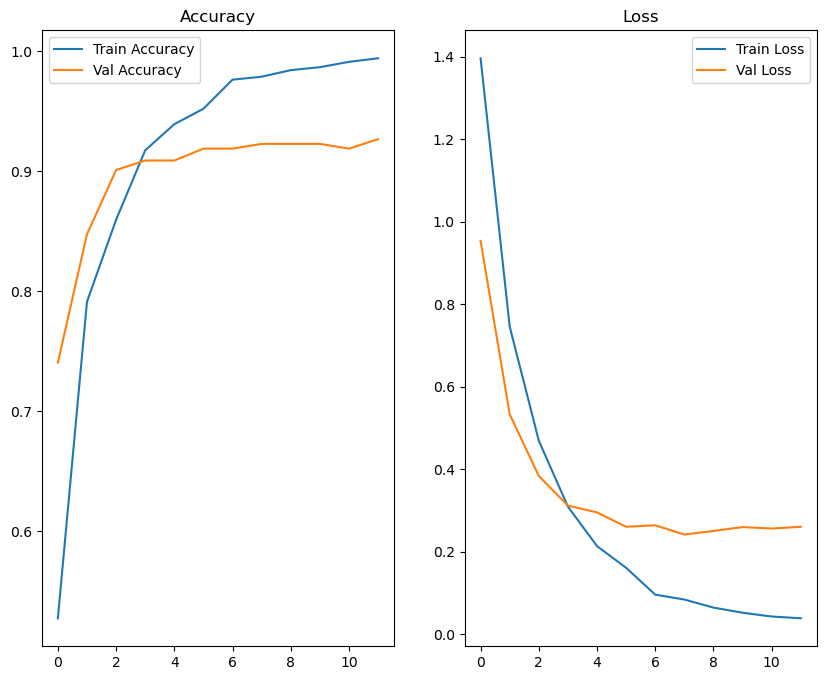

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 912ms/step - accuracy: 0.9350 - loss: 0.2217
Test accuracy: 0.9228, Loss: 0.2420
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step 
              precision    recall  f1-score   support

           0       0.94      0.87      0.90        69
           1       0.97      0.91      0.94       102
           2       0.93      0.93      0.93        88
           3       0.91      0.93      0.92       123
           4       0.92      0.96      0.94        89
           5       0.79      0.91      0.85        34

    accuracy                           0.92       505
   macro avg       0.91      0.92      0.91       505
weighted avg       0.92      0.92      0.92       505



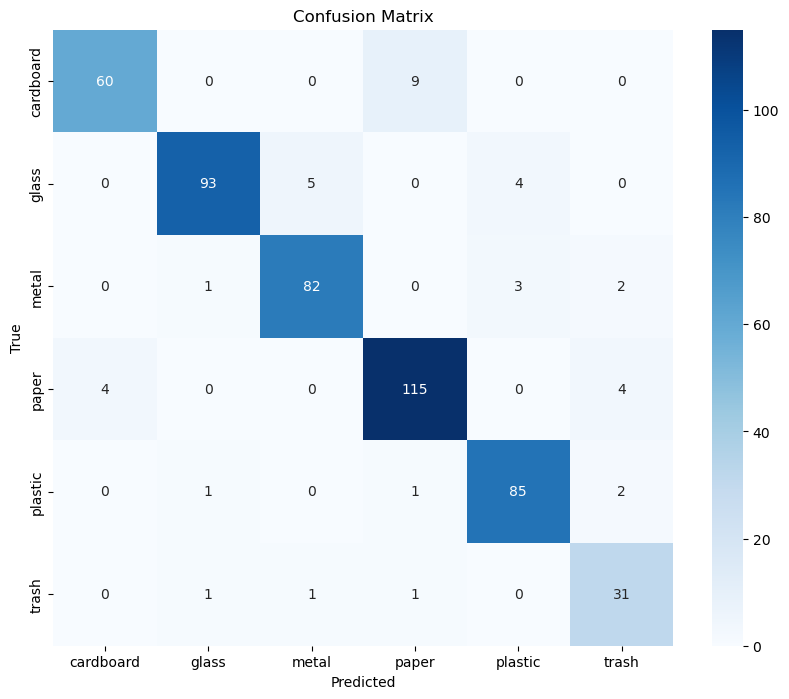

In [22]:
loss, accuracy = model.evaluate(val_ds)
print(f"Test accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

y_true = np.concatenate([y.numpy() for x, y in val_ds])
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


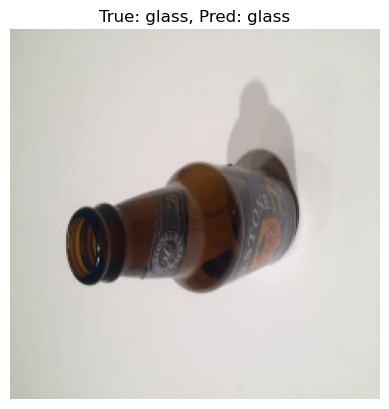

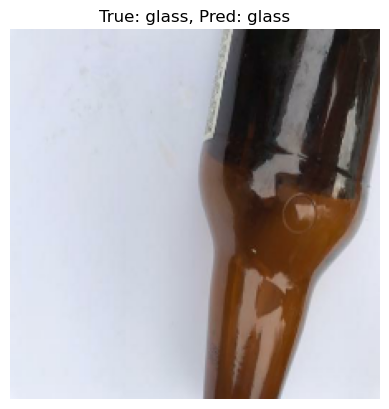

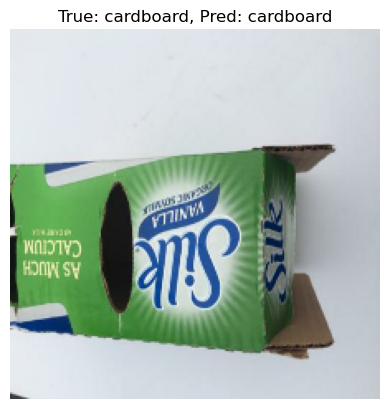

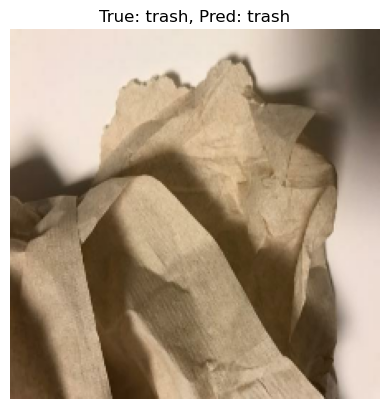

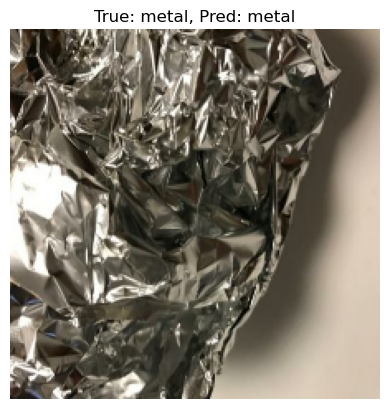

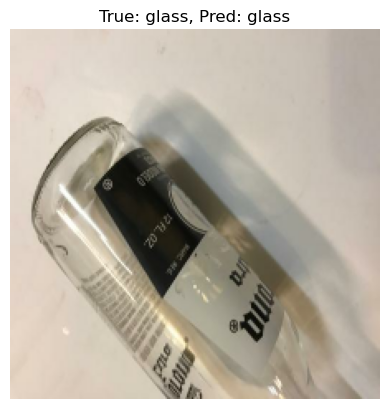

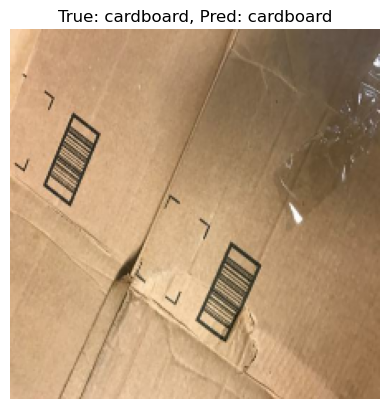

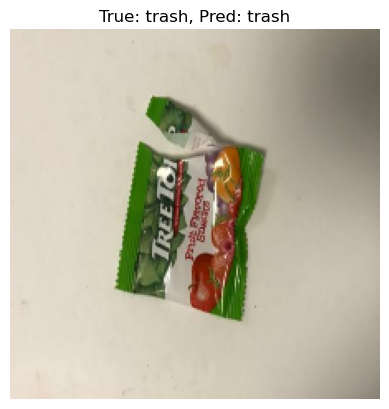

In [23]:
# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [24]:
# Save model after training
model.save("best_model.keras")  # Saves architecture + weights + training config
